## Configuration

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import math
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## Load the Dataset
  - kmrd dataset 이용

In [5]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [2]:
data_path = '/content/MyDrive/MyDrive/fastcampus/recommend/kmrd/kmr_dataset/datafile/kmrd-small'

In [3]:
def read_data(data_path) :

  df = pd.read_csv(os.path.join(data_path,'rates.csv'))
  train_df, val_df = train_test_split(df, test_size = 0.2, random_state = 1234, shuffle = True)
  return train_df, val_df


In [6]:
train_df, val_df = read_data(data_path)

In [7]:
print(train_df.shape)
print(val_df.shape)

(112568, 4)
(28142, 4)


In [8]:
!nvidia-smi

Sun Apr  4 16:41:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
val_df.shape

(28142, 4)

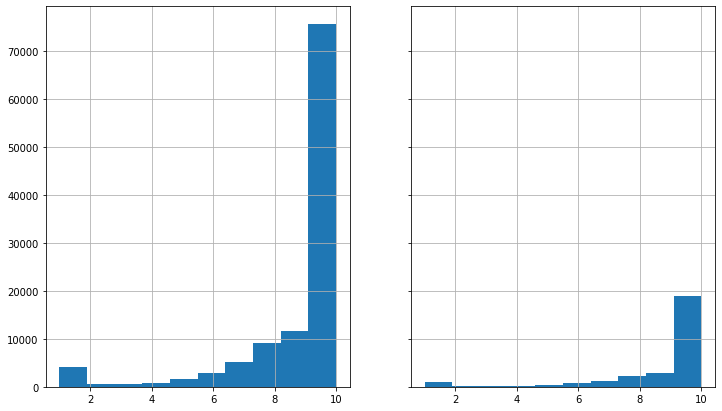

In [12]:
# rate에 대해서 histogram을 봐보자
fig, ax = plt.subplots(1,2, sharex = 'col', sharey = 'row', figsize=(12,7))
ax = ax.ravel()

train_df['rate'].hist(ax=ax[0])
val_df['rate'].hist(ax=ax[1])
plt.show()

In [13]:
train_df.describe()

,user,movie,rate,time
count,112568.000000,112568.000000,112568.000000,1.125680e+05
mean,14906.170350,10278.906252,8.948369,1.297174e+09
std,14526.408344,293.051318,2.114602,1.374920e+08
min,0.000000,10001.000000,1.000000,1.069340e+09
25%,2979.000000,10048.000000,9.000000,1.180148e+09
50%,9229.000000,10147.000000,10.000000,1.271166e+09
75%,24024.250000,10489.000000,10.000000,1.409228e+09
max,52026.000000,10998.000000,10.000000,1.576526e+09


## Load movie dataframe

In [22]:
movies_df = pd.read_csv(os.path.join(data_path, 'movies.txt'), sep='\t', encoding='utf-8')
movies_df = movies_df.set_index('movie')

castings_df = pd.read_csv(os.path.join(data_path, 'castings.csv'), encoding='utf-8')
countries_df = pd.read_csv(os.path.join(data_path, 'countries.csv'), encoding='utf-8')
genres_df = pd.read_csv(os.path.join(data_path, 'genres.csv'), encoding='utf-8')

# Get Genre information
genres = [(list(set(x['movie'].values))[0], '/'.join(x['genre'].values)) for index, x in genres_df.groupby('movie')]
combined_genres_df = pd.DataFrame(data=genres, columns = ['movie','genres'])
combined_genres_df = combined_genres_df.set_index('movie')

# Get casting infromation
castings = [(list(set(x['movie'].values))[0], x['people'].values) for index, x in castings_df.groupby('movie')]
combined_castings_df = pd.DataFrame(data= castings, columns = ['movie','people'])
combined_castings_df = combined_castings_df.set_index('movie')

# Get countries for movie information

countries = [(list(set(x['movie'].values))[0], ','.join(x['country'].values)) for index, x in countries_df.groupby('movie')]
combined_countries_df = pd.DataFrame(data=countries, columns = ['movie', 'country'])
combined_countries_df = combined_countries_df.set_index('movie')

movies_df = pd.concat([movies_df, combined_genres_df, combined_castings_df, combined_countries_df], axis=1)
movies_df.head()

,title,title_eng,year,grade,genres,people,country
movie,,,,,,,
10001,시네마 천국,"Cinema Paradiso , 1988",2013.0,전체 관람가,드라마/멜로/로맨스,"[4374, 178, 3241, 47952, 47953, 19538, 18991, ...","이탈리아,프랑스"
10002,빽 투 더 퓨쳐,"Back To The Future , 1985",2015.0,12세 관람가,SF/코미디,"[1076, 4603, 917, 8637, 5104, 9986, 7470, 9987]",미국
10003,빽 투 더 퓨쳐 2,"Back To The Future Part 2 , 1989",2015.0,12세 관람가,SF/코미디,"[1076, 4603, 917, 5104, 391, 5106, 5105, 5107,...",미국
10004,빽 투 더 퓨쳐 3,"Back To The Future Part III , 1990",1990.0,전체 관람가,서부/SF/판타지/코미디,"[1076, 4603, 1031, 5104, 10001, 5984, 10002, 1...",미국
10005,스타워즈 에피소드 4 - 새로운 희망,"Star Wars , 1977",1997.0,PG,판타지/모험/SF/액션,"[1007, 535, 215, 1236, 35]",미국


In [23]:
# 영화 데이터의 메타정보를 확인한다.

movieName_dict = movies_df.to_dict()['title']
genres_dict = movies_df.to_dict()['genres']